<a href="https://colab.research.google.com/github/shreyamaurya029/AI-vs-Human-/blob/main/Robertawithmorefeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer,RobertaModel, RobertaForSequenceClassification, AdamW, get_scheduler
from torch import nn
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import os

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/traindataset.csv')

In [ ]:
df.head(2)

,Text,Label,Vocab Size,Avg Word Length,Density,active,passive,noun,pron,verb,...,det,propn,part,intj,punct,text_str,Flesch Reading Ease,Gunning Fog Index,Perplexity,Burstness
0,['From what I remember it is because you are n...,0,142,4.169421,0.586777,12,0,51,27,44,...,22,6,3,0,27,['From what I remember it is because you are n...,69.542232,11.704588,99.070293,0.927330
1,['IT here - it is not unreasonable to expect t...,0,333,4.072503,0.455540,24,2,147,45,129,...,91,15,3,0,67,['IT here - it is not unreasonable to expect t...,62.762188,12.910424,179.229803,1.418219


In [ ]:
# Fill missing values and ensure text is of string type
df['Text'].fillna('', inplace=True)
df['Text'] = df['Text'].astype(str)

In [ ]:
text_column = 'Text'
label_column = 'Label'
feature_columns = ['Vocab Size', 'Avg Word Length', 'Density', 'active',
       'passive', 'noun', 'pron', 'verb', 'adj', 'adv', 'det', 'propn', 'part',
       'intj', 'punct', 'Flesch Reading Ease',
       'Gunning Fog Index', 'Perplexity' , 'Burstness']


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])

In [ ]:
class CombinedDataset(Dataset):
    def __init__(self, texts, additional_features, labels, tokenizer, max_length=128):
        self.texts = texts
        self.additional_features = additional_features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        additional_features = torch.tensor(self.additional_features[idx], dtype=torch.float)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        # Tokenize the text
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0).long()
        attention_mask = encoding['attention_mask'].squeeze(0).long()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'additional_features': additional_features,
            'labels': label
        }

In [ ]:
class RobertaWithFeatures(nn.Module):
    def __init__(self, model_name, feature_dim, num_labels):
        super(RobertaWithFeatures, self).__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.roberta.config.hidden_size + feature_dim, num_labels)

    def forward(self, input_ids, attention_mask, additional_features, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]

        combined_output = torch.cat((pooled_output, additional_features), dim=1)

        logits = self.classifier(combined_output)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return (loss, logits) if loss is not None else logits

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
model = RobertaWithFeatures('roberta-base', len(feature_columns), num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaWithFeatures(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
train_dataset = CombinedDataset(
    texts=train_df[text_column].tolist(),
    additional_features=train_df[feature_columns].values,
    labels=train_df[label_column].tolist(),
    tokenizer=tokenizer
)

test_dataset = CombinedDataset(
    texts=test_df[text_column].tolist(),
    additional_features=test_df[feature_columns].values,
    labels=test_df[label_column].tolist(),
    tokenizer=tokenizer
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model.train()
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            additional_features=batch['additional_features'],
            labels=batch['labels']
        )

        loss = outputs[0]
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/6567 [00:00<?, ?it/s]

In [ ]:
model_save_path = '/content/drive/MyDrive/Models/Roberta'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Models/Roberta


In [ ]:
import numpy as np

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            additional_features=batch['additional_features']
        )

        logits = outputs if isinstance(outputs, torch.Tensor) else outputs[1]
        predicted_labels = torch.argmax(logits, dim=-1).cpu().numpy()

        # Ensure predicted_labels is a 1-dimensional array
        if predicted_labels.ndim == 0:
            predicted_labels = np.expand_dims(predicted_labels, axis=0)

        predictions.extend(predicted_labels)
        true_labels.extend(batch['labels'].cpu().numpy())

# Convert lists to numpy arrays for consistency
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate precision
precision = precision_score(true_labels, predictions)

# Calculate recall
recall = recall_score(true_labels, predictions)

# Calculate F1-score
f1 = f1_score(true_labels, predictions)

# Generate classification report
class_report = classification_report(true_labels, predictions, target_names=['Human', 'Machine'])

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(class_report)

Accuracy: 0.9976
Precision: 0.9954
Recall: 0.9998
F1-Score: 0.9976

Classification Report:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00      4405
     Machine       1.00      1.00      1.00      4351

    accuracy                           1.00      8756
   macro avg       1.00      1.00      1.00      8756
weighted avg       1.00      1.00      1.00      8756



In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/testdataset.csv')

In [ ]:
test_data.head(2)

,Text,Label,Vocab Size,Avg Word Length,Density,active,passive,noun,pron,verb,...,det,propn,part,intj,punct,text_str,Flesch Reading Ease,Gunning Fog Index,Perplexity,Burstness
0,['The military has its own justice system beca...,1,90,5.256579,0.592105,0,3,42,6,28,...,16,5,0,0,16,['The military has its own justice system beca...,33.833333,18.916667,61.989642,1.014427
1,"[""Cargo ships are not allowed to carry weapons...",1,93,5.520000,0.744000,4,1,39,1,22,...,9,3,1,0,15,"[""Cargo ships are not allowed to carry weapons...",38.363182,16.330736,82.057648,0.709295


In [ ]:
test_data['Text'].fillna('', inplace=True)
test_data['Text'] = test_data[text_column].astype(str)

In [ ]:
test_data[feature_columns] = scaler.transform(test_data[feature_columns])

In [ ]:
test1_dataset = CombinedDataset(
    texts=test_data[text_column].tolist(),
    additional_features=test_data[feature_columns].values,
    labels=test_data[label_column].tolist(),
    tokenizer=tokenizer
)

# Create dataloader
test1_loader = DataLoader(test1_dataset, batch_size=16, shuffle=False)

In [ ]:
model.eval()
predictions1 = []
true_labels1 = []

with torch.no_grad():
    for batch in test1_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            additional_features=batch['additional_features']
        )

        logits = outputs if isinstance(outputs, torch.Tensor) else outputs[1]
        predicted_labels = torch.argmax(logits, dim=-1).cpu().numpy()

        # Ensure predicted_labels is a 1-dimensional array
        if predicted_labels.ndim == 0:
            predicted_labels = np.expand_dims(predicted_labels, axis=0)

        predictions1.extend(predicted_labels)
        true_labels1.extend(batch['labels'].cpu().numpy())

# Convert lists to numpy arrays for consistency
predictions1 = np.array(predictions1)
true_labels1 = np.array(true_labels1)

In [ ]:
accuracy = accuracy_score(true_labels1, predictions1)
precision = precision_score(true_labels1, predictions1)
recall = recall_score(true_labels1, predictions1)
f1 = f1_score(true_labels1, predictions1)
class_report = classification_report(true_labels1, predictions1, target_names=['Human', 'Machine'])

In [ ]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(class_report)

Test Accuracy: 0.9973
Test Precision: 0.9951
Test Recall: 0.9996
Test F1-Score: 0.9973

Classification Report:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00      2432
     Machine       1.00      1.00      1.00      2432

    accuracy                           1.00      4864
   macro avg       1.00      1.00      1.00      4864
weighted avg       1.00      1.00      1.00      4864



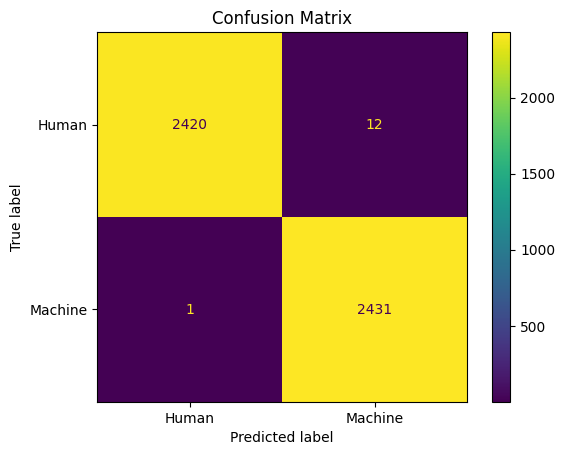

In [ ]:

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels1, predictions1)
ConfusionMatrixDisplay(cm, display_labels=['Human', 'Machine']).plot()
plt.title('Confusion Matrix')
plt.show()

0.9973273026315789


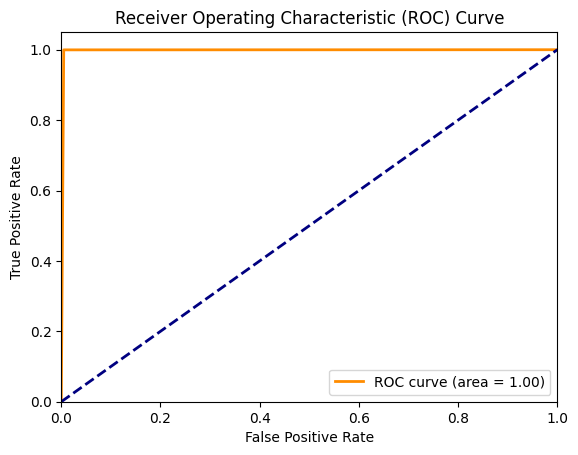

In [ ]:
# AUC-ROC Curve
fpr, tpr, _ = roc_curve(true_labels1, predictions1, pos_label=1)
roc_auc = roc_auc_score(true_labels1, predictions1)

print(roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()